In [1]:
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
import zipfile
from datetime import datetime
import seaborn as sns

In [2]:
## TXF
data = pd.read_csv('C:/Users/ASUS/Desktop/TXF1-分鐘-成交價.txt')
data.head()

,Date,Time,Open,High,Low,Close,TotalVolume
0,2000/1/4,09:01:00,8688.0,8688.0,8676.0,8680.0,67
1,2000/1/4,09:02:00,8662.0,8698.0,8662.0,8698.0,52
2,2000/1/4,09:03:00,8698.0,8700.0,8690.0,8700.0,31
3,2000/1/4,09:04:00,8700.0,8700.0,8680.0,8700.0,38
4,2000/1/4,09:05:00,8700.0,8700.0,8652.0,8680.0,44


In [3]:
## TotalVolume改Volume
data = data.rename(columns = dict(zip(data.columns, ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])))
## 將index改為時間
data.Date = pd.to_datetime(data.Date)
data.Time = pd.to_timedelta(data.Time)
data = data.set_index(data.Date + data.Time).drop(columns = ['Date','Time'])

## 用map抓時間資料
data['Year'] = data.index.map(lambda x: x.year)
data['Month'] = data.index.map(lambda x: x.month)
data['Weekday'] = data.index.map(lambda x: x.weekday)+1
data['Hour'] = data.index.map(lambda x: x.hour)
data.head()

,Open,High,Low,Close,Volume,Year,Month,Weekday,Hour
2000-01-04 09:01:00,8688.0,8688.0,8676.0,8680.0,67,2000,1,2,9
2000-01-04 09:02:00,8662.0,8698.0,8662.0,8698.0,52,2000,1,2,9
2000-01-04 09:03:00,8698.0,8700.0,8690.0,8700.0,31,2000,1,2,9
2000-01-04 09:04:00,8700.0,8700.0,8680.0,8700.0,38,2000,1,2,9
2000-01-04 09:05:00,8700.0,8700.0,8652.0,8680.0,44,2000,1,2,9


In [4]:
## FOI
FOI = pd.read_csv('C:/Users/ASUS/Desktop/Foreign_OI.txt')
FOI.head()

,Unnamed: 0,Date,Foreign_OI
0,0,2010/1/4,2645.0
1,1,2010/1/5,2356.0
2,2,2010/1/6,3990.0
3,3,2010/1/7,-3326.0
4,4,2010/1/8,-4730.0


In [5]:
## 將index改為時間
FOI.index = pd.to_datetime(FOI.Date)
FOI = FOI.drop(columns = ['Unnamed: 0','Date'])
FOI

,Foreign_OI
Date,
2010-01-04,2645.0
2010-01-05,2356.0
2010-01-06,3990.0
2010-01-07,-3326.0
2010-01-08,-4730.0
...,...
2021-04-23,-29457.0
2021-04-26,-30486.0
2021-04-27,-31451.0


In [6]:
#data.columns  ### ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Weekday','Hour']
## 把data轉成日K
data = data.drop(columns = ['Year', 'Month', 'Weekday','Hour'])
data = data.resample('1d').agg(dict(zip(data.columns, ['first','max','min','last','sum'])))
data

,Open,High,Low,Close,Volume
2000-01-04,8688.0,8939.0,8650.0,8843.0,2800
2000-01-05,8718.0,8870.0,8671.0,8810.0,2854
2000-01-06,8840.0,9005.0,8820.0,8850.0,2501
2000-01-07,8781.0,8870.0,8711.0,8829.0,2409
2000-01-08,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...
2020-10-20,12888.0,12905.0,12813.0,12872.0,95118
2020-10-21,12873.0,12946.0,12758.0,12787.0,96558
2020-10-22,12787.0,12894.0,12707.0,12861.0,138829
2020-10-23,12860.0,12884.0,12795.0,12846.0,100541


In [7]:
## 再把日K資料和外資未平倉量資料合併
df = pd.concat([data.Close, FOI.Foreign_OI], axis = 1, join = 'inner')
df

,Close,Foreign_OI
2010-01-04,8166.0,2645.0
2010-01-05,8178.0,2356.0
2010-01-06,8320.0,3990.0
2010-01-07,8259.0,-3326.0
2010-01-08,8278.0,-4730.0
...,...,...
2020-10-19,12888.0,28769.0
2020-10-20,12872.0,26384.0
2020-10-21,12787.0,27466.0
2020-10-22,12861.0,31361.0


In [8]:
## 高原圖
# Make the plot
x_sma = []
y_lma = []
z_RonMDD = []

## i短天期範圍，j長天期範圍
for i in range(5,45,5):
    for j in range(60,125,5):
        
        N1 = i
        N2 = j
        df['SMA'] = df.Foreign_OI.rolling(N1).mean().dropna()
        df['LMA'] = df.Foreign_OI.rolling(N2).mean().dropna()
        
        signal = np.where((df.SMA >= df.LMA), 1, -1)
        signal_df = pd.Series(signal, index = df.index)
        
        return_df = pd.concat([df.Close.pct_change(), signal_df.shift(2)], axis = 1).dropna()
        return_df.columns = ['d_return','position']
        return_df['return'] = return_df.d_return * return_df.position
        
        
        MDD_series = return_df['return'].dropna().cumsum().cummax()-return_df['return'].dropna().cumsum()
        MDD = max(MDD_series)
        Return_on_MDD = return_df['return'].dropna().cumsum()[-1] / MDD

        x_sma.append(i)
        y_lma.append(j)
        z_RonMDD.append(Return_on_MDD)

In [9]:
xyz = {"sma" : x_sma,
       "lma" : y_lma,
       "Return/MDD" : z_RonMDD}
xyz_data = DataFrame(xyz)
xyz_data

,sma,lma,Return/MDD
0,5,60,3.487720
1,5,65,2.488783
2,5,70,2.939559
3,5,75,2.049680
4,5,80,3.088024
...,...,...,...
99,40,100,0.612647
100,40,105,0.579106
101,40,110,0.911030
102,40,115,0.977974


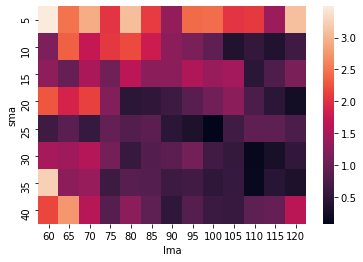

In [10]:
xyz_data_wide = xyz_data.pivot_table( index='sma', columns='lma', values='Return/MDD')
sns.heatmap(xyz_data_wide)
plt.show()